# E. coli Glycolytic Network Construction
## Growth Medium: Glucose
Growth data obtained from the following sources: 
- Gerosa, Luca et al. “Pseudo-transition Analysis Identifies the Key Regulators of Dynamic Metabolic Adaptations from Steady-State Data.” Cell systems vol. 1,4 (2015): 270-82. doi:10.1016/j.cels.2015.09.008


- Volkmer, Benjamin, and Matthias Heinemann. “Condition-dependent cell volume and concentration of Escherichia coli to facilitate data conversion for systems biology modeling.” PloS one vol. 6,7 (2011): e23126. doi:10.1371/journal.pone.0023126


### Import packages

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass


import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt

import cobra
from cobra.io.json import load_json_model as load_cobra_json_model

import mass
from mass import MassConfiguration, MassModel, MassMetabolite, MassReaction, Simulation
from mass.io.json import save_json_model as save_mass_json_model
from mass.visualization import plot_comparison, plot_time_profile


print(f"COBRApy version: {cobra.__version__}")
print(f"MASSpy version: {mass.__version__}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-22
COBRApy version: 0.23.0
MASSpy version: 0.1.7


### Set solver

In [2]:
MASSCONFIGURATION = MassConfiguration()
MASSCONFIGURATION.solver = "gurobi"

## Load COBRA model

In [3]:
cobra_model = load_cobra_json_model(f"./models/cobra/iML1515.json")

## Obtain Flux State
### Load growth data

In [4]:
medium = "Glucose"
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data",
    index_col=0
)
'''
flux_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="flux_data_reduced",
    index_col=0
)
flux_data = flux_data.loc[lambda x: x['Growth Medium'] == medium]
flux_data = flux_data.drop("Growth Medium", axis=1)
flux_data

,Flux (mmol * gDW-1 * h-1)
Rxn,
GLCptspp,9.613287
PGI,5.698950
PFK,7.057500
FBP,0.000000
FBA,7.057500
...,...
L_LACD2,0.000000
CYTBO3_4pp,38.191466
CYTBDpp,0.000000


### Set bounds
#### Growth rate and media

In [5]:
biomass_rxn = cobra_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M
growth_rate = flux_data.loc[biomass_rxn.id][0] #This index is hard-coded based on which column has the flux value
biomass_rxn.bounds = (0, growth_rate)
biomass_rxn.bounds

(0, 0.455338783207954)

In [6]:
EX_glc__D_e = cobra_model.reactions.EX_glc__D_e
medium_uptake = flux_data.loc[EX_glc__D_e.id][0] #This index is hard-coded based on which column has the flux value
EX_glc__D_e.bounds = (medium_uptake, 0)
EX_glc__D_e.bounds

(-9.655, 0)

### Formulate QP minimization for fluxes

In [7]:
v_vars = []
v_data = []

# For irreversible enzyme pairs, flux data is given as Enzyme1 - Enzyme2 = value.
# To ensure all enzymes have some flux, add a percentage of the net flux for each enzyme
# The netflux will still remain the same value.
reverse_flux_percent = 0.1

irreversible_enzyme_pairs = [["PFK", "FBP"], ["PYK", "PPS"]]

for rid, flux in flux_data.itertuples():
    # Make adjustments to net flux of PFK/FBP and PYK/PPS to ensure
    # no target flux value is 0 in order to create an enzyme module.
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_data.loc[irreversible_enzyme_pair, "Flux (mmol * gDW-1 * h-1)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
            print(rid, flux)
            
    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)
F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
cobra_model.objective = objective[0]
cobra_model.objective_direction = "min"

flux_solution = cobra_model.optimize()
flux_solution

PFK 7.76325
FBP 0.7057500000000001
PYK 2.73493
PPS 0.24863000000000002


,fluxes,reduced_costs
CYTDK2,0.000000,0.0
XPPT,0.000000,0.0
HXPRT,0.000000,0.0
NDPK5,0.000000,0.0
SHK3Dr,0.211771,0.0
...,...,...
MPTS,0.000000,0.0
MOCOS,0.000000,0.0
BMOGDS2,0.000000,0.0
FESD2s,0.000000,0.0


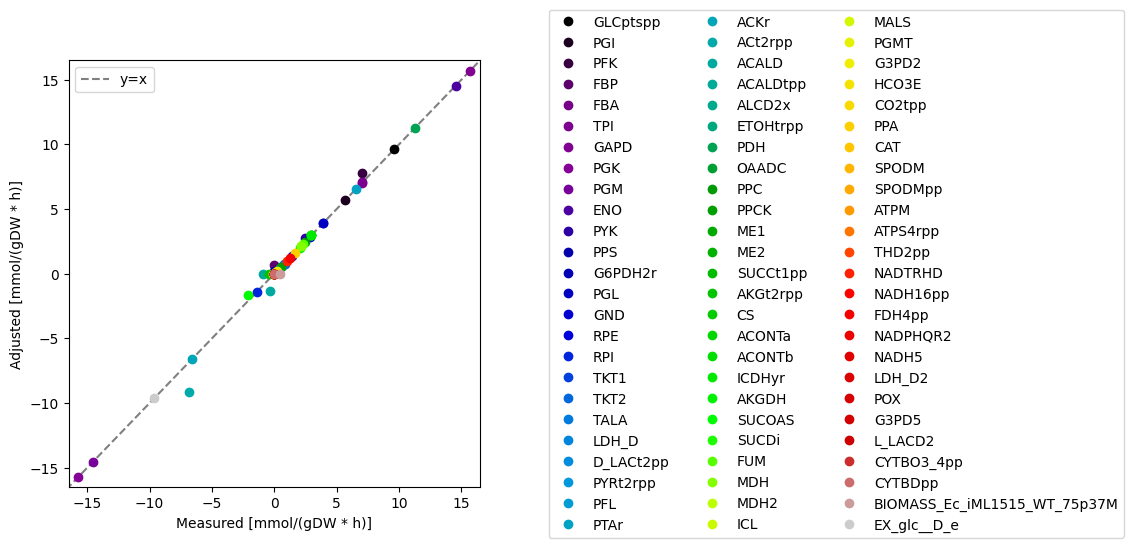

In [8]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Flux (mmol * gDW-1 * h-1)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_data.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

#### Export data for analysis

In [9]:
flux_data_for_comparison = pd.concat(objs=(flux_data, flux_solution.fluxes), axis=1).dropna()
flux_data_for_comparison.index.name = "ID"
flux_data_for_comparison.columns = ["Initial", "Adjusted"]
flux_data_for_comparison.to_csv("./data/analysis_data/fluxes_extended.csv")

## Create MASS Model

In [10]:
# Create MassModel
mass_model = MassModel("CentralMetabolism", array_type="DataFrame")

# Reactions to extract into subnetwork
reaction_list = [
    "GLCptspp",
"PGI",
"PFK",
"FBP",
"FBA",
"TPI",
"GAPD",
"PGK",
"PGM",
"ENO",
"PYK",
"PPS",
"G6PDH2r",
"PGL",
"GND",
"RPE",
"RPI",
"TKT1",
"TKT2",
"TALA",
"LDH_D",
"D_LACt2pp",
"PYRt2rpp",
"PFL",
"PTAr",
"ACKr",
"ACt2rpp",
"ACALD",
"ACALDtpp",
"ALCD2x",
"ETOHtrpp",
"PDH",
"OAADC",
"PPC",
"PPCK",
"ME1",
"ME2",
"SUCCt1pp",
"AKGt2rpp",
"CS",
"ACONTa",
"ACONTb",
"ICDHyr",
"AKGDH",
"SUCOAS",
"SUCDi",
"FUM",
"MDH",
"MDH2",
"ICL",
"MALS",
"PGMT",
"G3PD2",
"HCO3E",
"CO2tpp",
"PPA",
"CAT",
"SPODM",
"SPODMpp",
"ATPM",
"ATPS4rpp",
"THD2pp",
"NADTRHD",
"NADH16pp",
"FDH4pp",
"NADPHQR2",
"NADH5",
"LDH_D2",
"POX",
"G3PD5",
"L_LACD2",
"CYTBO3_4pp",
"CYTBDpp",
]

cobra_reactions = cobra_model.reactions.get_by_any(reaction_list)
mass_model.add_reactions([MassReaction(rxn) for rxn in cobra_reactions])
mass_model

Name,CentralMetabolism
Memory address,0x01bfee56b048
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,0/70
Number of reactions,73
Number of genes,66
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Convert flux units to M/s

In [11]:
T = 313.15
gas_constant = 0.008314
e_coli_density = 1.1 # g / mL assumption
volume = 3.2  # femtoliter

# Perform conversions
doubling_time_per_minute = np.log(2) / growth_rate * 60
cell_gDW = 42000 * doubling_time_per_minute**-1.232 * 1e-15
real_cell_total_weight = e_coli_density * (volume * 1e-12) # fL --> mL

# Assume water is 70%
adj_volume = volume * 0.7
gDW_L_conversion_factor = real_cell_total_weight / (adj_volume * 1e-15)

for reaction in mass_model.reactions.get_by_any(reaction_list):
    flux = flux_solution[reaction.id]
    reaction.steady_state_flux = flux * gDW_L_conversion_factor * 0.001 / 3600 

## Set equilibrium constants

In [12]:
Keq_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="Keq_data",
    index_col=0
)
for reaction in mass_model.reactions.get_by_any(reaction_list):
    reaction.Keq = Keq_data.loc[reaction.Keq_str][0]

In [13]:
conc_data = pd.read_excel(
    io="./data/growth_data_extended.xlsx",
    sheet_name="conc_data",
    index_col=0
)
conc_data = conc_data.loc[lambda x: x['Growth Medium'] == "Glucose"]
conc_data = conc_data.drop("Growth Medium", axis=1)
conc_data

,Concentration (mol * L-1)
ID,
10fthf_c,1.051286e-04
13dpg_c,5.507545e-05
23dhb_c,1.380000e-04
2ddg6p_c,1.247644e-05
2dmmql8,1.051286e-04
...,...
utp_c,8.290000e-03
val__L_c,4.020000e-03
xu5p__D_c,6.447318e-04


### Add PFK1 activator GDP

In [14]:
#gdp_c = MassMetabolite(cobra_model.metabolites.gdp_c)
# Set the activator as a constant
#gdp_c.fixed = True

#mass_model.add_metabolites(gdp_c)

### Set initial concentrations from growth data

In [15]:
mass_model.update_initial_conditions({
    mid: value for mid, value in conc_data.itertuples()
})

# Fix hydrogen and water as constants and set concentration to 1.
for metabolite in mass_model.metabolites.get_by_any(["h2o_c", "h_c"]):
    metabolite.fixed = True
    metabolite.initial_condition = 1

missing_ics = mass_model.metabolites.query(lambda m: m.initial_condition is None)
# Provide initial guesses for missing metabolites (pi_c, g3p_c, and lac__D_c)
print(missing_ics)
for metabolite in missing_ics:
    metabolite.initial_condition = 0.001

[<MassMetabolite glc__D_p at 0x1bfee56b508>, <MassMetabolite 6pgl_c at 0x1bfee55bfc8>, <MassMetabolite lac__D_c at 0x1bfee5569c8>, <MassMetabolite h_p at 0x1bfee5561c8>, <MassMetabolite lac__D_p at 0x1bfee556108>, <MassMetabolite pyr_p at 0x1bfee553188>, <MassMetabolite ac_p at 0x1bfee54fc08>, <MassMetabolite acald_c at 0x1bfee54f588>, <MassMetabolite acald_p at 0x1bfee54c5c8>, <MassMetabolite etoh_c at 0x1bfee54cf48>, <MassMetabolite etoh_p at 0x1bfee54c888>, <MassMetabolite succ_p at 0x1bfee546dc8>, <MassMetabolite akg_p at 0x1bfee5464c8>, <MassMetabolite glx_c at 0x1bfee538a08>, <MassMetabolite co2_p at 0x1bfee5353c8>, <MassMetabolite h2o2_c at 0x1bfee531788>, <MassMetabolite o2s_c at 0x1bfee531708>, <MassMetabolite h2o2_p at 0x1bfee5311c8>, <MassMetabolite o2_p at 0x1bfee531148>, <MassMetabolite o2s_p at 0x1bfee531108>, <MassMetabolite for_p at 0x1bfee527d08>, <MassMetabolite lac__L_c at 0x1bfee520048>]


mass\core\mass_model.py:1967 UserWarning: No metabolite found for '10fthf_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '23dhb_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2ddg6p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dmmql8'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '2dr5p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4abut_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '4hbz_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for '5mthf'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'aacoa_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acgam1p_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'acorn_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'ade_c'
mass\core\mass_model.py:1967 UserWarning: No metabolite found for 'adn_c'
mass\core\mass_

### Formulate QP minimization for concentrations

In [16]:
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

In [17]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_feasible_qp_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)

conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
g6p_c,2.242760e-03,0.0
glc__D_p,1.000000e-03,0.0
pep_c,1.714436e-06,0.0
pyr_c,1.186056e-04,0.0
f6p_c,3.346820e-04,0.0
...,...,...
Keq_POX,7.927669e+15,0.0
Keq_G3PD5,3.001950e+06,0.0
Keq_L_LACD2,2.291433e+06,0.0
Keq_CYTBO3_4pp,2.128717e+15,0.0


In [18]:
mass_model

Name,CentralMetabolism
Memory address,0x01bfee56b048
Stoichiometric Matrix,70x73
Matrix Rank,58
Number of metabolites,70
Initial conditions defined,70/70
Number of reactions,73
Number of genes,66
Number of enzyme modules,0
Number of groups,0
Objective expression,0


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'gthox_c', 'dctp_c', 'mocogdp', 'histd_c', 'spmd_c', 'clpn161', 'ala_B_c', 'malcoa', 'mql8', 'mobd', 'skm_c', '5mthf', 'clpn181', 'asp__L_c', 'pe160', 'gdp_c', 'clpn160', 'imp_c', 'gmp_c', 'phe__L_c', 'quln_c', 'fmn_c', 'asn__L_c', 'glu__L_c', 'phpyr_c', 'thr__L_c', 'damp_c', 'his__L_c', 'udcpdp', 'gthrd_c', 'hxan_c', 'met__L_c', 'thmpp', 'dttp_c', 'tre6p_c', 'adpglc_c', 'dgmp_c', 'prpp_c', 'pg160', 'utp_c', '2dr5p_c', 'citr__L_c', 'ile__L_c', '4abut_c', 'orn_c', 'gln__L_c', 'hemeO', 'hcys__L_c', '2dmmql8', 'chor', '4hbz_c', '2ddg6p_c', 'csn_c', 'h_c', 'pheme', 'acorn_c', 'aps_c', 'cys__L_c', 'ptrc_c', 'cmp_c', 'nh4_c', 'lys__L_c', 'val__L_c', 'sarcs_c', 'pe161', 'adn_c', 'tyr__L_c', 'aacoa_c', 'cbasp_c', 'gsn_c', 'gam6p_c', 'acgam1p_c', 'dgsn_c', 'gua_c', 'udpglcur_c', 'leu__L_c', 'cytd_c', 'uri_c', 'pg161', 'trp__L_c', 'gtp_c', 'hom__L_c', 'enter', 'pg181', 'glcn_c', 'mnl1p_c', 'mococdp', 'h2o_c', 'ctp_c', 'gly_c', 

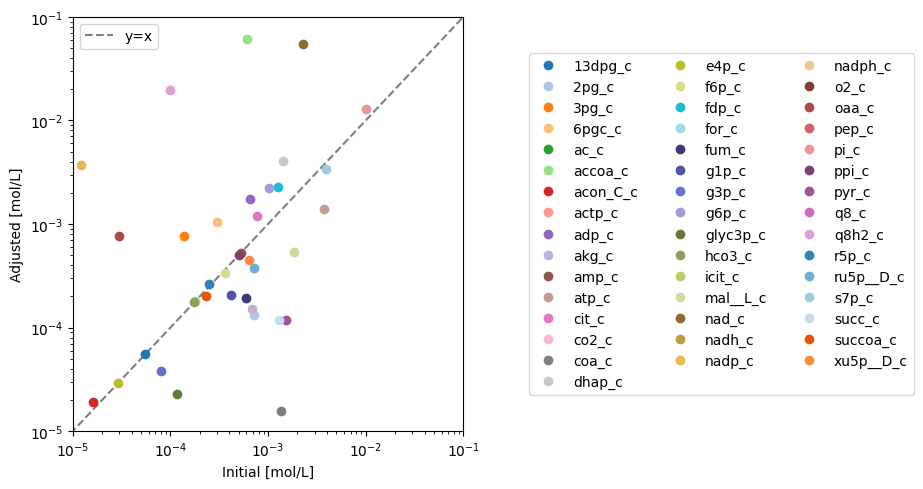

In [19]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_data["Concentration (mol * L-1)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_data.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [20]:
conc_data_for_comparison = pd.concat(objs=(conc_data, conc_solution.concentrations), axis=1).dropna()
conc_data_for_comparison.index.name = "ID"
conc_data_for_comparison.columns = ["Initial", "Adjusted"]
conc_data_for_comparison.to_csv("./data/analysis_data/concentrations_extended.csv")
conc_data_for_comparison

,Initial,Adjusted
ID,,
13dpg_c,0.000055,5.507545e-05
2pg_c,0.000725,1.312710e-04
3pg_c,0.000138,7.623383e-04
6pgc_c,0.000302,1.040886e-03
ac_c,0.000660,3.489012e+04
accoa_c,0.000606,6.123914e-02
acon_C_c,0.000016,1.893466e-05
actp_c,0.001070,4.984383e-01
adp_c,0.000656,1.755910e-03


mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'Keq_EX_fe2_e', 'Keq_G5SD', 'Keq_TREH', 'Keq_MALTPTtexi', 'Keq_EAR181x', 'Keq_AB6PGH', 'Keq_DXPS', 'Keq_GPDDA1pp', 'Keq_INDOLEtex', 'Keq_SELtex', 'Keq_SUCCtex', 'Keq_EX_3hpppn_e', 'Keq_GPDDA5pp', 'Keq_EX_ile__L_e', 'Keq_EX_g3ps_e', 'Keq_OCTDPS', 'Keq_CDAPPA140', 'Keq_NACtex', 'Keq_BWCOGDS1', 'Keq_ARHGDx', 'Keq_EX_sq_e', 'Keq_EX_tartr__D_e', 'Keq_UM4PL', 'Keq_GUAtpp', 'Keq_G1PACT', 'Keq_EX_acser_e', 'Keq_EX_dhps_e', 'Keq_EX_so2_e', 'Keq_METGLCURtex', 'Keq_EX_tmao_e', 'Keq_THDPS', 'Keq_METGLCUR', 'Keq_MDDCP4pp', 'Keq_APG3PAT120', 'Keq_ORNDC', 'Keq_AGM4PA', 'Keq_ISETACabcpp', 'Keq_EDTXS3', 'Keq_THRt2pp', 'Keq_EX_but_e', 'Keq_HYXNtpp', 'Keq_EX_4abut_e', 'Keq_UAGDP', 'Keq_TYRPtex', 'Keq_FALGTHLs', 'Keq_MINOHPtexi', 'Keq_LPLIPAL2ATG180', 'Keq_COLIPAabcpp', 'Keq_THMDt2pp_copy1', 'Keq_SDPDS', 'Keq_EAR181y', 'Keq_DMSOR2pp', 'Keq_EX_fald_e', 'Keq_EAR60y', 'Keq_F6PP', 'Keq_FEENTERES', 'Keq_PE181abcpp', 'Keq_ASNNpp', 'Keq_DHGLYH'

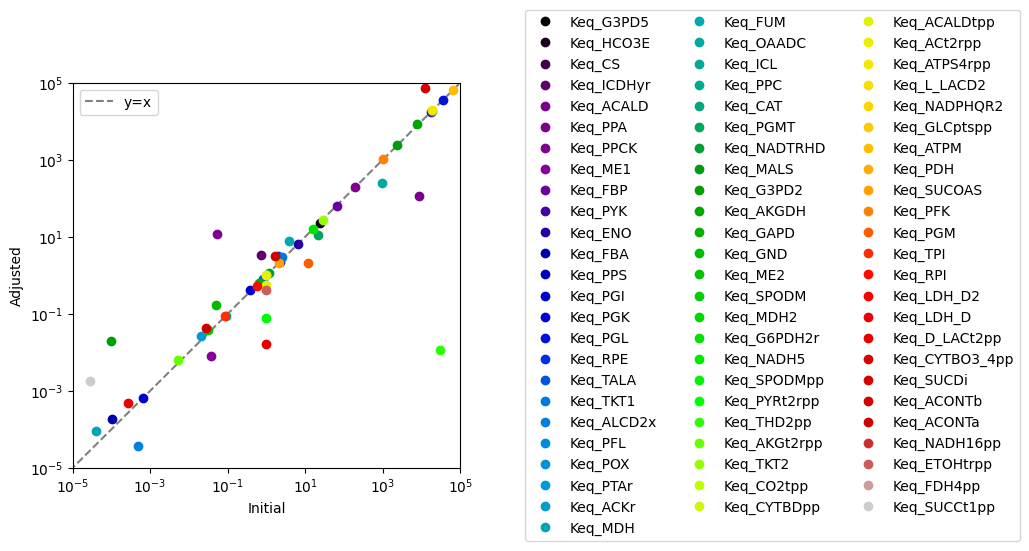

In [21]:
Keq_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

plot_comparison(
    x=Keq_data["Equilibrium Constant"], y=conc_solution,
    compare="Keqs", ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    mass_model, conc_solution, concentrations=True, Keqs=True, inplace=True);

#### Export data for analysis

In [22]:
Keq_data_for_comparison = pd.concat(objs=(Keq_data, conc_solution.Keqs), axis=1).dropna()
Keq_data_for_comparison.index.name = "ID"
Keq_data_for_comparison.columns = ["Initial", "Adjusted"]
Keq_data_for_comparison.to_csv("./data/analysis_data/equilibrium_constants_extended.csv")
Keq_data_for_comparison

,Initial,Adjusted
ID,,
Keq_G3PD5,3.097852e+09,3.001950e+06
Keq_HCO3E,2.352797e+01,2.352797e+01
Keq_CS,4.465331e+06,4.465331e+06
Keq_ICDHyr,7.288431e-01,3.285634e+00
Keq_ACALD,8.884664e+03,1.129093e+02
...,...,...
Keq_ACONTa,2.777306e-02,4.330926e-02
Keq_NADH16pp,4.079883e+06,1.724759e+13
Keq_ETOHtrpp,1.000000e+00,4.279681e-01


In [23]:
from mass.util import qcqa_model
qcqa_model(mass_model, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════════╕
│ MODEL ID: CentralMetabolism                  │
│ SIMULATABLE: False                           │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             MISSING PARAMETERS               │
│ ============================================ │
│ Reaction Parameters                          │
│ ---------------------                        │
│ GLCptspp: kf                                 │
│ PGI: kf                                      │
│ PFK: kf                                      │
│ FBP: kf                                      │
│ FBA: kf                                      │
│ TPI: kf                                      │
│ GAPD: kf                                     │
│ PGK: kf                                      │
│ PGM: kf                                      │
│ ENO: kf                                      │
│ PYK: kf           

In [24]:
# Fix Metabolite IDs as SBML compatible before next step
for metabolite in mass_model.metabolites:
    if metabolite.id[0].isdigit():
        metabolite.id = f"_{metabolite.id}"
mass_model.repair()

In [25]:
from pprint import pprint
pprint(vars(mass_model.metabolites.co2_c))

{'_annotation': {'bigg.metabolite': ['co2'],
                 'biocyc': ['META:CARBON-DIOXIDE'],
                 'chebi': ['CHEBI:23011',
                           'CHEBI:3283',
                           'CHEBI:48829',
                           'CHEBI:16526',
                           'CHEBI:13283',
                           'CHEBI:13285',
                           'CHEBI:13284',
                           'CHEBI:13282'],
                 'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/2ec3da94-5f50-4525-81b1-5607c5c7a3d3',
                              '32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/compound/05f60af4-0a3f-4ead-9a29-33bb0f123379'],
                 'hmdb': ['HMDB01967'],
                 'inchi_key': ['CURLTUGMZLYLDI-UHFFFAOYSA-N'],
                 'kegg.compound': ['C00011'],
                 'kegg.drug': ['D00004'],
                 'metanetx.chemical': ['MNXM13'],
                 'reactome.compound': ['29376',
                                       '56685

In [26]:
#Set the metabolite for CO2 as a fixed metabolite using the "fixed" attribute (e.g., co2_c.fixed = True, etc.)
mass_model.metabolites.co2_c.fixed = True
mass_model.metabolites.co2_c.initial_condition = 0.001

In [27]:
mass_model.initial_conditions

{<MassMetabolite g6p_c at 0x1bfee56b548>: 0.0022427597397947966,
 <MassMetabolite glc__D_p at 0x1bfee56b508>: 0.0010000000000000002,
 <MassMetabolite pep_c at 0x1bfee56b808>: 1.714435837052253e-06,
 <MassMetabolite pyr_c at 0x1bfee56b9c8>: 0.00011860564523667403,
 <MassMetabolite f6p_c at 0x1bfee567d88>: 0.0003346820494132951,
 <MassMetabolite adp_c at 0x1bfee567b48>: 0.0017559100629837947,
 <MassMetabolite atp_c at 0x1bfee567948>: 0.001396281522602528,
 <MassMetabolite fdp_c at 0x1bfee5672c8>: 0.0022719758095301754,
 <MassMetabolite h_c at 0x1bfee567f48>: 1,
 <MassMetabolite h2o_c at 0x1bfee567808>: 1,
 <MassMetabolite pi_c at 0x1bfee5677c8>: 0.012842366575737422,
 <MassMetabolite dhap_c at 0x1bfee567648>: 0.0040275786763128004,
 <MassMetabolite g3p_c at 0x1bfee5673c8>: 3.844954326127119e-05,
 <MassMetabolite _13dpg_c at 0x1bfee565cc8>: 5.507544833963519e-05,
 <MassMetabolite nad_c at 0x1bfee565c08>: 0.05425077760211174,
 <MassMetabolite nadh_c at 0x1bfee565b88>: 1.2552577911449938e-0

In [28]:
n_models = 2

In [32]:
conc_solver = ConcSolver(
    mass_model,
    excluded_metabolites=["h_c", "h2o_c"],
    constraint_buffer=1,
    equilibrium_reactions=[x.id for x in mass_model.reactions if x.steady_state_flux == 0]

)

conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(mass_model.fixed),
)
for variable in conc_solver.variables:
    try:
        met = mass_model.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=4)
conc_samples

OptimizationError: CVA warmup found no feasible solutions. Ensure the systems has the appropriate variables and constraints by excluding certain metabolites (e.g. hydrogen) and reactions (e.g. boundary reactions), and by indicating the equilibrium reactions.

### Balance network with pseudoreactions and calculate PERCs

In [33]:
models_for_ensemble = []
for idx, conc_sample in conc_solution.iterrows():
    # Make copy of new model
    new_model = mass_model.copy()
    new_model.id += "_C{0:d}".format(idx)
    print(f"Creating model {new_model.id}")
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)
    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

AttributeError: 'ConcSolution' object has no attribute 'iterrows'

In [31]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_wo_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol_orig, flux_sol_orig = sim.simulate(reference_model, time=(0, tfinal))
conc_sol_orig.view_time_profile()

IndexError: list index out of range

In [29]:
conc_sol_pert, flux_sol_pert = sim.simulate(
    reference_model, time=(0, tfinal), perturbations={"kf_CS": "kf_CS * 0.05"})
conc_sol_pert.view_time_profile()

NameError: name 'sim' is not defined

In [30]:
#Citrate should deplete
print("Citrate WT is: " + str(conc_sol_orig.cit_c[-1]))
print("Citrate with CS inhibited is: " + str(conc_sol_pert.cit_c[-1]))

#succoa should deplete
print("Succoa WT is: " + str(conc_sol_orig.succoa_c[-1]))
print("Succoa with CS inhibited is: " + str(conc_sol_pert.succoa_c[-1]))

#Malate should accumulate
print("Malate WT is: " + str(conc_sol_orig.mal__L_c[-1]))
print("Malate with CS inhibited is: " + str(conc_sol_pert.mal__L_c[-1]))

#accoa should accumulate
print("Accoa original is: " + str(conc_sol_orig.accoa_c[-1]))
print("Accoa original is: " + str(conc_sol_pert.accoa_c[-1]))

NameError: name 'conc_sol_orig' is not defined

#### Save a reference MASS model w/o enzymes

In [31]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", 
    tfinal=tfinal)
if conc_sol and flux_sol:
    reference_model.update_initial_conditions(conc_sol)
    reference_model.update_parameters({f"v_{k}": v for k, v in flux_sol.items()})
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/without_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

NameError: name 'sim' is not defined

## Create Enzyme Modules

Assume 90% of flux goes through the major isozyme, the remaining through the minor isozyme

In [32]:
from construction_functions import make_enzyme_module_from_dir

In [33]:
isozyme1_percent = 0.9
isozyme2_percent = 0.1

# Isozymes and flux split percentages,
isozymes_and_flux_splits = {
    "PFK": {
        "PFK1": isozyme1_percent,
        "PFK2": isozyme2_percent,
    },
    "FBP": {
        "FBP1": isozyme1_percent,
        "FBP2": isozyme2_percent,
    },
    "FBA": {
        "FBA1": isozyme1_percent,
        "FBA2": isozyme2_percent,
    },
    "PGM": {
        "PGMi": isozyme1_percent,
        "PGMd": isozyme2_percent,
    },
    "PYK": {
        "PYK1": isozyme1_percent,
        "PYK2": isozyme2_percent,
    },
}
        
isozymes_and_flux_splits

{'PFK': {'PFK1': 0.9, 'PFK2': 0.1},
 'FBP': {'FBP1': 0.9, 'FBP2': 0.1},
 'FBA': {'FBA1': 0.9, 'FBA2': 0.1},
 'PGM': {'PGMi': 0.9, 'PGMd': 0.1},
 'PYK': {'PYK1': 0.9, 'PYK2': 0.1}}

In [34]:
final_ensemble = []
for model in models_for_ensemble:
    enzyme_modules = {}
    for reaction in model.reactions.get_by_any(reaction_list):
        # PGM & PGK needs flux flipped since enzyme module stoichiometry
        # is reversed compared to lone reaction.
        if reaction.id in ["PGK", "PGM"]:
            flux = -reaction.steady_state_flux
        else:
            flux = reaction.steady_state_flux
        # Make isozymes
        if reaction.id in isozymes_and_flux_splits:
            isozymes_and_flux_split = isozymes_and_flux_splits[reaction.id]
            isozyme_modules = []
            for isozyme, flux_split in isozymes_and_flux_split.items():
                enzyme_module = make_enzyme_module_from_dir(
                    enzyme_id=isozyme,
                    steady_state_flux=flux * flux_split, # Split flux for isozymes
                    metabolite_concentrations=model.initial_conditions,
                    path_to_dir="./data/enzyme_module_data",
                    kcluster=1,
                    enzyme_gpr=reaction.gene_reaction_rule,
                    zero_tol=1e-10)
                isozyme_modules += [enzyme_module]
            enzyme_modules[reaction] = isozyme_modules
        else:
            enzyme_module = make_enzyme_module_from_dir(
                enzyme_id=reaction.id,
                steady_state_flux=flux,
                metabolite_concentrations=new_model.initial_conditions,
                path_to_dir="./data/enzyme_module_data",
                kcluster=1,
                enzyme_gpr=reaction.gene_reaction_rule,
                zero_tol=1e-10)
            enzyme_modules[reaction] = [enzyme_module]
    for reaction_to_remove, enzymes_to_add in enzyme_modules.items():
        model.remove_reactions([reaction_to_remove])
        for enzyme in enzymes_to_add:
            model = model.merge(enzyme, inplace=True)
    final_ensemble += [model]
    print(f"Finished {model.id}")

# Inspect a model

In [35]:
reference_model = models_for_ensemble[0].copy()
reference_model.id = "Glycolysis_Ref_w_Enzymes"
sim = Simulation(reference_model)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

tfinal = 1e6
conc_sol, flux_sol = sim.simulate(reference_model, time=(0, tfinal))
conc_sol.view_time_profile(plot_function="semilogx")


IndexError: list index out of range

#### Save a reference MASS model w/ enzymes

In [36]:
conc_sol, flux_sol = sim.find_steady_state(
    models=reference_model, strategy="simulate", update_values=True,
    tfinal=tfinal)
if conc_sol and flux_sol:
    # Save a reference MASS model
    save_mass_json_model(
        mass_model=reference_model,
        filename=f"./models/mass/with_enzymes/{reference_model.id}.json")
    print(f"Saving {reference_model.id}")
reference_model

NameError: name 'sim' is not defined

## Simulate to steady state and export ensemble

In [37]:
sim = Simulation(final_ensemble[0])
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9
sim.add_models(final_ensemble[1:], disable_safe_load=True)
for model in final_ensemble:
    # Attempt to determine steady state
    conc_sol, flux_sol = sim.find_steady_state(
        models=model, strategy="simulate", update_values=True,
        tfinal=tfinal)
    if conc_sol and flux_sol:
        # Save a reference MASS model
        save_mass_json_model(
            mass_model=model,
            filename=f"./models/mass/with_enzymes/{model.id}.json")
        print(f"Saving {model.id}")
    else:
        print(f"No steady state for {model.id}.")

IndexError: list index out of range